In [1]:
import os
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 12
plt.rcParams['figure.dpi']= 120
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge

import seaborn as sns
import pymc3 as pm

seed = 2127

In [2]:
data = pd.read_csv("unconv_MV_v4.csv")
scaler = StandardScaler()
dataSt = pd.DataFrame(scaler.fit_transform(data))
dataSt.columns = data.columns
dataSt.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,-1.723412,-0.982256,-0.817030,-0.298603,2.358297,0.352948,1.152048,-1.399936
1,-1.706091,-0.881032,-0.463751,0.444147,-0.141332,-0.209104,-0.280931,-0.553322
2,-1.688771,-0.327677,-1.008148,1.841224,1.748113,-0.209104,2.518377,-0.859996
3,-1.671450,0.903875,1.401098,-0.599240,-0.592585,0.186414,-0.280931,0.919141
4,-1.654129,0.853263,0.138561,0.373409,-2.640962,1.081534,-0.214280,-0.648602


In [3]:
dataSt = dataSt[["Por", "Perm", "Brittle", "Prod"]]
dataSt.head()

,Por,Perm,Brittle,Prod
0,-0.982256,-0.817030,2.358297,-1.399936
1,-0.881032,-0.463751,-0.141332,-0.553322
2,-0.327677,-1.008148,1.748113,-0.859996
3,0.903875,1.401098,-0.592585,0.919141
4,0.853263,0.138561,-2.640962,-0.648602


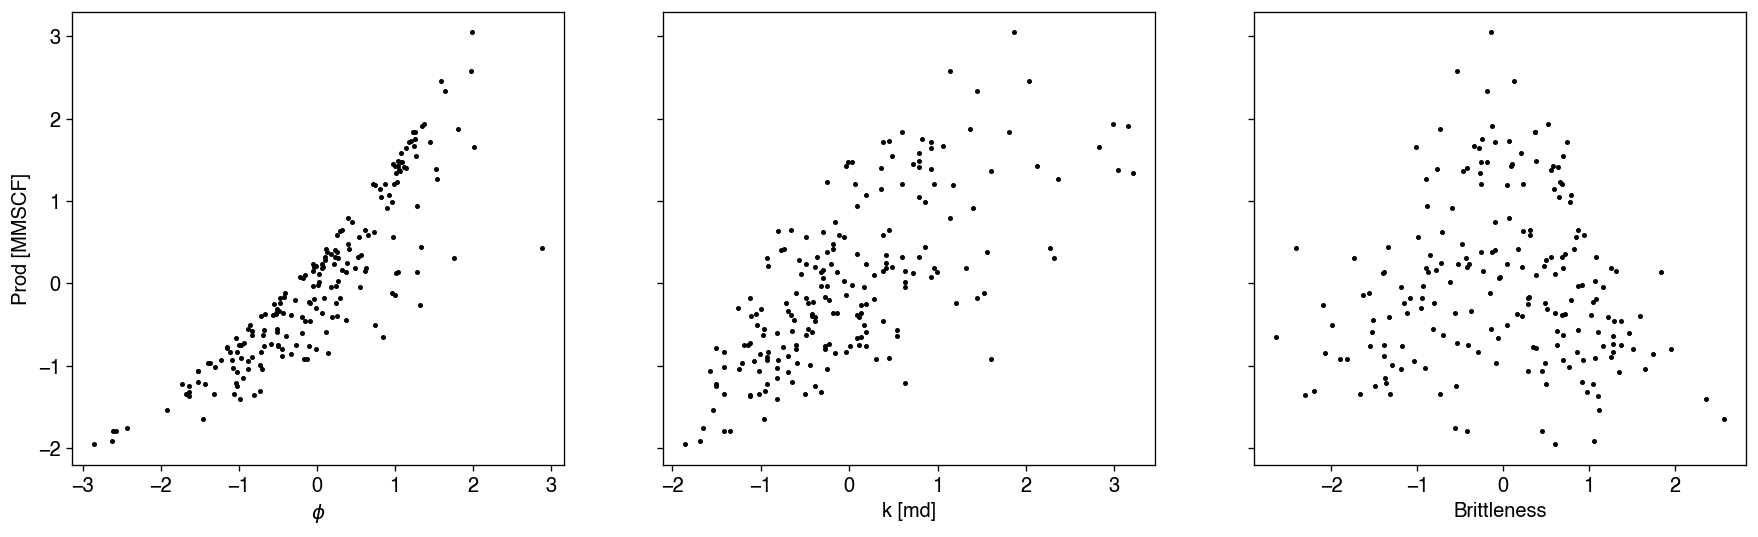

In [4]:
fig, ax = plt.subplots(ncols = 3, figsize = (18,5), sharey = True)
ax[0].scatter(dataSt["Por"], dataSt["Prod"], s = 4, color = "black")
ax[0].set_ylabel("Prod [MMSCF]")
ax[0].set_xlabel(r"$\phi$")
ax[1].scatter(dataSt["Perm"], dataSt["Prod"], s = 4, color = "black")
ax[1].set_xlabel("k [md]")
ax[2].scatter(dataSt["Brittle"], dataSt["Prod"], s = 4, color = "black")
ax[2].set_xlabel("Brittleness")
plt.show()

In [5]:
x0 = dataSt["Por"]
x1 = dataSt["Perm"]
x2 = dataSt["Brittle"]
y = dataSt["Prod"]

beta0List = []
beta1List = []
beta2List = []
lambdaList = np.logspace(-1,4, 50)

for lambd in lambdaList:
    with pm.Model() as bayesLasso:
        # declare priors
        intercept = pm.Flat("intercept")
        sigmaSq = pm.Exponential("sigma2", lam = 1)
        beta0 = pm.Laplace("beta0", mu = 0, b = sigmaSq**0.5/lambd)
        beta1 = pm.Laplace("beta1", mu = 0, b = sigmaSq**0.5/lambd)
        beta2 = pm.Laplace("beta2", mu = 0, b = sigmaSq**0.5/lambd)

        # construct model
        modelMean = intercept + (beta0 * x0) + (beta1 * x1) + (beta2 * x2)

        # define likelihood
        likelihood = pm.Normal('likelihood', mu = modelMean, sd = sigmaSq**0.5, observed = y)

        # set up posterior sampling 
        step = pm.NUTS(target_accept = 0.95)
        start = pm.find_MAP()
    
    beta0List.append(float(start["beta0"]))
    beta1List.append(float(start["beta1"]))
    beta2List.append(float(start["beta2"]))


In [6]:
X = dataSt[["Por", "Perm", "Brittle"]]
y = dataSt["Prod"]

coefsRidge = []
coefsLasso = []

for l in lambdaList:
    model = Ridge(alpha = l)
    model.fit(X,y)
    coefsRidge.append(model.coef_)

lambdaListLasso = np.logspace(-3,1,100)
for l in lambdaListLasso:
    model = Lasso(alpha = l)
    model.fit(X,y)
    coefsLasso.append(model.coef_)


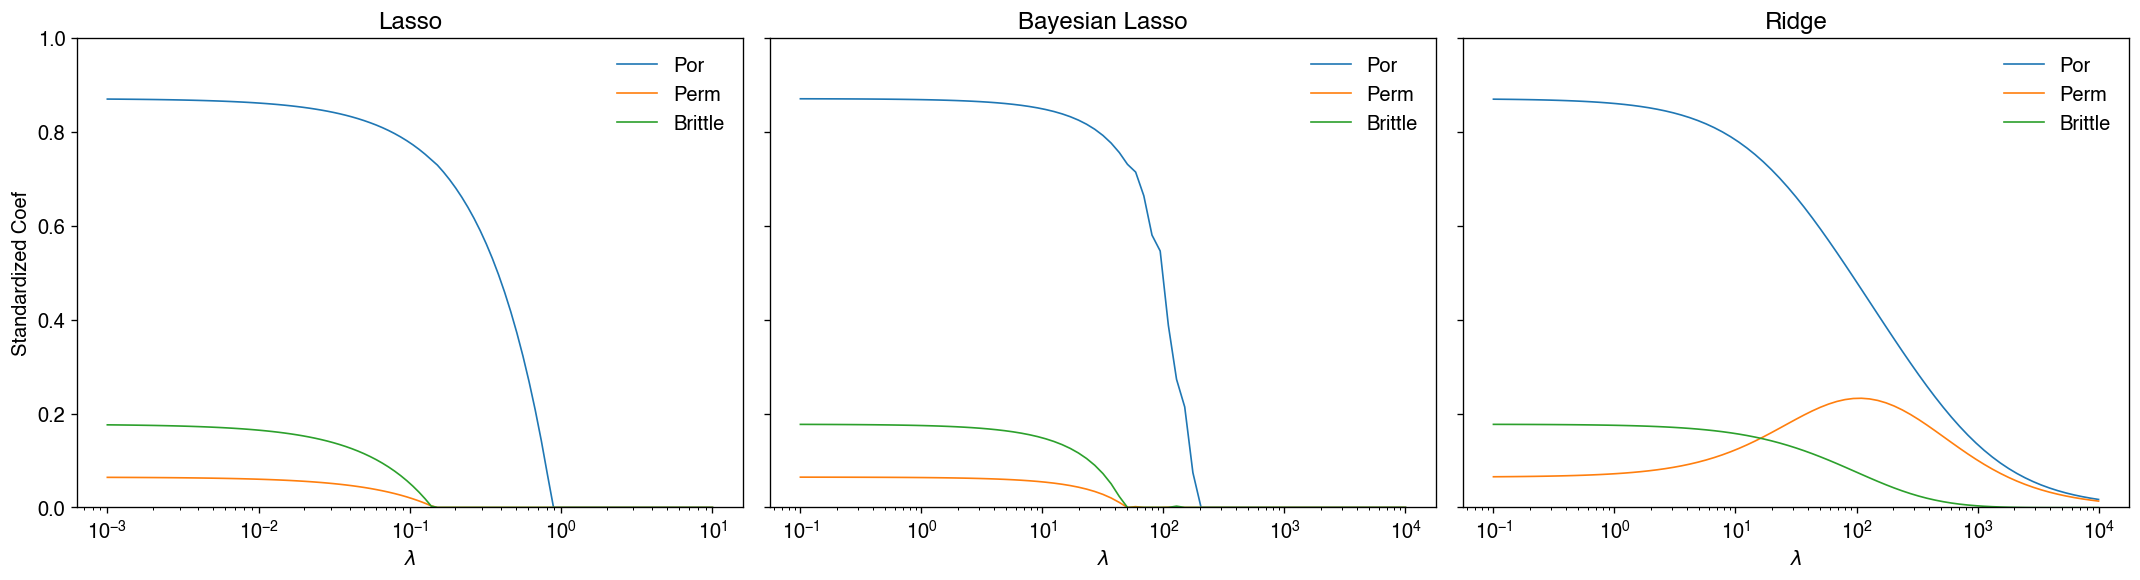

In [7]:
fig, ax = plt.subplots(ncols = 3, figsize = (18,5), sharey = True)

coefLassoArr = np.array(coefsLasso)
labels = ["Por", "Perm", "Brittle"]
for f in range(3):
    ax[0].plot(lambdaListLasso, coefLassoArr[:,f], label = labels[f], lw = 1)
ax[0].set_xscale('log')
ax[0].set_xlabel(r"$\lambda$")
ax[0].set_title("Lasso")
ax[0].legend(frameon = False)
ax[0].set_ylabel("Standardized Coef")
ax[0].set_ylim([0,1])

ax[1].plot(lambdaList, beta0List, label = "Por", lw = 1)
ax[1].plot(lambdaList, beta1List, label = "Perm", lw = 1)
ax[1].plot(lambdaList, beta2List, label = "Brittle", lw = 1)
ax[1].set_title("Bayesian Lasso")
ax[1].set_xlabel(r"$\lambda$")

ax[1].legend(frameon = False)
ax[1].set_xscale('log')

coefRidgeArr = np.array(coefsRidge)
labels = ["Por", "Perm", "Brittle"]
for f in range(3):
    ax[2].plot(lambdaList, coefRidgeArr[:,f], label = labels[f], lw = 1)
ax[2].set_xscale('log')
ax[2].set_xlabel(r"$\lambda$")
ax[2].set_title("Ridge")
ax[2].legend(frameon = False)


plt.tight_layout()
plt.show()